In [397]:
from itertools import combinations
import os

import pandas as pd
import numpy as np

import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

In [398]:
TASK = 'multiclass'
FOLDER = '2025-09-12'
NESTED_CV_RESULTS_PATH = f"./out/models/toxicity/entire-chat-{TASK}-classification/nested-cv-results/{FOLDER}"

all_scores = {}
for file in os.listdir(NESTED_CV_RESULTS_PATH):
    if file.endswith(".csv"):
        model_name = file.split('.')[0]
        df = pd.read_csv(os.path.join(NESTED_CV_RESULTS_PATH, file))
        if "test_cost" in df.columns:
            all_scores[model_name] = df["test_cost"].values
        elif "per_chat_cost" in df.columns:
            all_scores[model_name] = df["per_chat_cost"].values
        # if "test_f1_weighted" in df.columns:
        #     all_scores[model_name] = df["test_f1_weighted"].values
        # elif "per_chat_f1_weighted" in df.columns:
        #     all_scores[model_name] = df["per_chat_f1_weighted"].values

# order by first prefix separated by -
ordered_scores = dict(sorted(all_scores.items(), key=lambda item: item[0].split('-')[0]))

In [399]:
def plot_pvalue_matrix(all_scores, confidence_level=0.95, title_suffix=""):
    """
    Plot a heatmap of pairwise p-values with customizable confidence level.
    
    Parameters:
    - all_scores: dict with model names as keys and score arrays as values
    - confidence_level: float, confidence level (e.g., 0.95 for 95%)
    - title_suffix: str, additional text for the plot title
    """
    from matplotlib.colors import TwoSlopeNorm
    
    alpha = 1 - confidence_level
    model_names = list(all_scores.keys())
    
    p_value_matrix = pd.DataFrame(
        np.ones((len(model_names), len(model_names))), 
        columns=model_names, 
        index=model_names
    )

    for m1, m2 in combinations(model_names, 2):
        scores1 = all_scores[m1]
        scores2 = all_scores[m2]

        # Perform the paired t-test
        t_stat, p_value = stats.ttest_rel(scores1, scores2)
        
        # Store the p-value in the matrix (symmetrically)
        p_value_matrix.loc[m1, m2] = p_value
        p_value_matrix.loc[m2, m1] = p_value

    plt.figure(figsize=(12, 8))
    
    # Center the colormap around the alpha level
    vmax = max(0.05, alpha * 5)  # Extend range to show more variation
    
    sns.heatmap(
        p_value_matrix, 
        annot=True,         # Show the p-values in the cells
        cmap='coolwarm_r',  # Use a reversed colormap (low p-values are "hot"/red)
        fmt=".3f",          # Format numbers to 3 decimal places
        linewidths=.5,
        norm=TwoSlopeNorm(vmin=0, vcenter=alpha, vmax=vmax),  # Center at alpha
        cbar_kws={'label': 'P-value'}
    )
    
    # Add a horizontal line at the alpha level for reference
    cbar = plt.gca().collections[0].colorbar
    cbar.ax.axhline(y=alpha, color='black', linestyle='--', linewidth=1)
    cbar.ax.text(0.5, alpha, f'α', transform=cbar.ax.transData, 
                ha='left', va='center', fontsize=8, bbox=dict(boxstyle="round,pad=0.3", 
                facecolor="white", alpha=0.8))

    title = f'Pairwise P-value Matrix of Classifier Performance (Weighted F1-Score)\nConfidence Level: {confidence_level*100:.0f}%'
    if title_suffix:
        title += f' - {title_suffix}'
    
    plt.title(title)
    plt.tight_layout()
    plt.show()
    
    return p_value_matrix

In [400]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from itertools import combinations
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_dual_confidence_pvalue_matrix(all_scores, confidence_level1=0.90, confidence_level2=0.99, title_suffix=""):
    """
    Plot a single heatmap of pairwise p-values with dual confidence levels.
    Bottom-left triangle uses confidence_level1, top-right triangle uses confidence_level2.
    
    Parameters:
    - all_scores: dict with model names as keys and score arrays as values
    - confidence_level1: float, confidence level for bottom-left triangle (e.g., 0.90 for 90%)
    - confidence_level2: float, confidence level for top-right triangle (e.g., 0.99 for 99%)
    - title_suffix: str, additional text for the plot title
    """
    alpha1 = 1 - confidence_level1
    alpha2 = 1 - confidence_level2
    model_names = list(all_scores.keys())
    
    p_value_matrix = pd.DataFrame(
        np.ones((len(model_names), len(model_names))), 
        columns=model_names, 
        index=model_names
    )
    for m1, m2 in combinations(model_names, 2):
        scores1 = all_scores[m1]
        scores2 = all_scores[m2]
        # Perform the paired t-test
        t_stat, p_value = stats.ttest_rel(scores1, scores2)
        
        # Store the p-value in the matrix (symmetrically)
        p_value_matrix.loc[m1, m2] = p_value
        p_value_matrix.loc[m2, m1] = p_value
        
    # Create matrices for each triangle with different color scales
    lower_triangle = p_value_matrix.copy()
    upper_triangle = p_value_matrix.copy()
    
    # Apply masks to separate triangles
    lower_mask = np.triu(np.ones_like(p_value_matrix, dtype=bool))
    upper_mask = np.tril(np.ones_like(p_value_matrix, dtype=bool))
    
    # Set color limits for each triangle
    vmax1 = max(0.1, alpha1 * 2)
    # For upper triangle, center the colormap around alpha2
    vmax2 = max(0.05, alpha2 * 5)  # Extend range to show more variation
    
    plt.figure(figsize=(12, 8))
    ax = plt.gca() # Get current axes
    
    # Plot lower triangle with confidence_level1 colors
    sns.heatmap(
        lower_triangle, 
        mask=lower_mask,
        annot=True,
        cmap='coolwarm_r',
        fmt=".3f",
        linewidths=.5,
        vmin=0,
        vmax=vmax1,
        cbar=False,
        ax=ax
    )
    
    # Create a custom colormap for the upper triangle centered at alpha2
    from matplotlib.colors import TwoSlopeNorm
    
    # Plot upper triangle with confidence_level2 colors, centered at alpha2
    sns.heatmap(
        upper_triangle, 
        mask=upper_mask,
        annot=True,
        cmap='coolwarm_r',
        fmt=".3f",
        linewidths=.5,
        norm=TwoSlopeNorm(vmin=0, vcenter=alpha2, vmax=vmax2),
        cbar=False,
        ax=ax
    )
    
    # === MODIFIED SECTION FOR VERTICAL COLORBARS ===
    
    # Use make_axes_locatable to create space for colorbars
    divider = make_axes_locatable(ax)
    
    # Create a new axes on the left for the first colorbar
    cax1 = divider.append_axes("left", size="5%", pad=1.7)
    
    # Create a new axes on the right for the second colorbar
    cax2 = divider.append_axes("right", size="5%", pad=0.5)

    # --- Colorbar for lower triangle (confidence_level1) ---
    norm1 = Normalize(vmin=0, vmax=vmax1)
    sm1 = plt.cm.ScalarMappable(cmap='coolwarm_r', norm=norm1)
    sm1.set_array([])
    
    cbar1 = plt.colorbar(sm1, cax=cax1, orientation='vertical')
    cbar1.set_label(f'P-value (Lower Triangle)', rotation=270, labelpad=20)

    cbar1.ax.text(0, alpha1, f'α', transform=cbar1.ax.transData, 
                ha='left', va='center', fontsize=8, bbox=dict(boxstyle="round,pad=0.3", 
                facecolor="white", alpha=0.8))

    cbar1.ax.axhline(y=alpha1, color='black', linestyle='--', linewidth=1)
    # Position ticks and labels on the left
    cax1.yaxis.set_ticks_position('left')
    cax1.yaxis.set_label_position('left')

    # --- Colorbar for upper triangle (confidence_level2) with centered norm ---
    norm2 = TwoSlopeNorm(vmin=0, vcenter=alpha2, vmax=vmax2)
    sm2 = plt.cm.ScalarMappable(cmap='coolwarm_r', norm=norm2)
    sm2.set_array([])
    
    cbar2 = plt.colorbar(sm2, cax=cax2, orientation='vertical')
    cbar2.set_label(f'P-value (Upper Triangle)', rotation=270, labelpad=15)
    cbar2.ax.text(0, alpha2, f'α', transform=cbar2.ax.transData, 
                ha='left', va='center', fontsize=8, bbox=dict(boxstyle="round,pad=0.3", 
                facecolor="white", alpha=0.8))
    cbar2.ax.axhline(y=alpha2, color='black', linestyle='--', linewidth=1)
    
    # === END OF MODIFIED SECTION ===
    
    # Main title
    title = f'Dual Confidence P-value Matrix\nLower Triangle: {confidence_level1*100:.0f}% confidence, Upper Triangle: {confidence_level2*100:.0f}% confidence'
    if title_suffix:
        title += f' - {title_suffix}'
    
    ax.set_title(title) # Set title on the axes object
    plt.show()
    
    return p_value_matrix

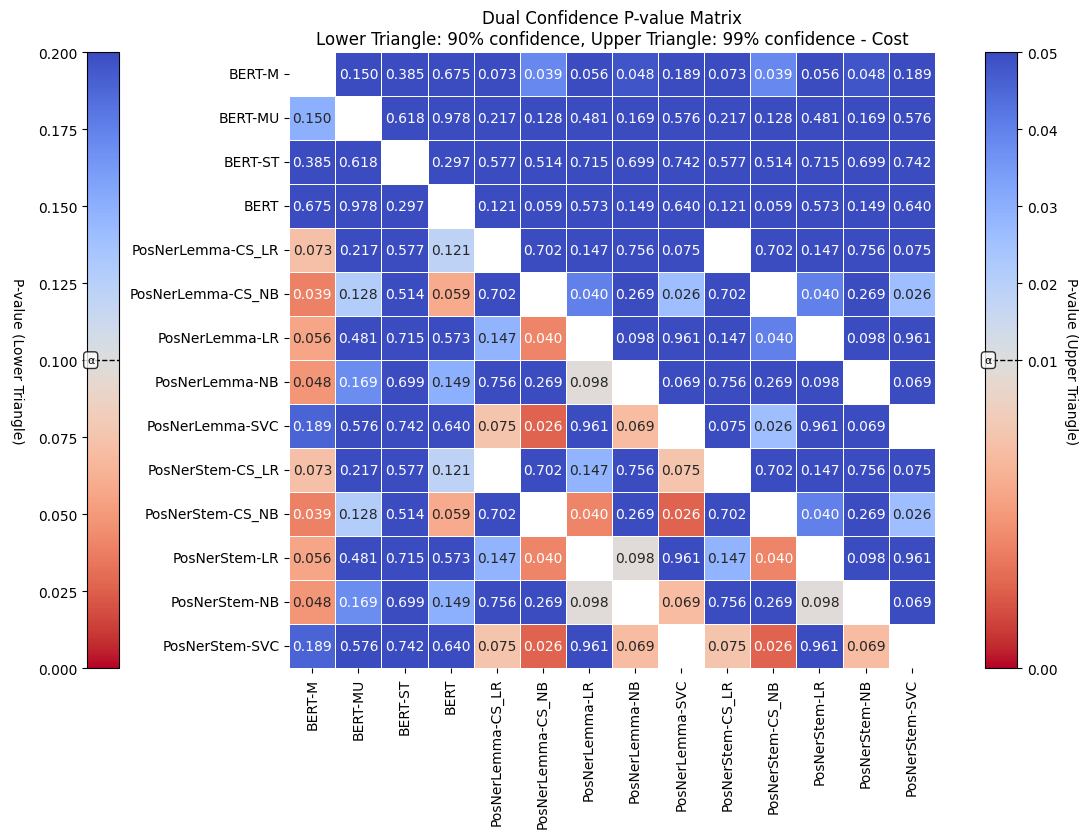

In [401]:
p_matrix = plot_dual_confidence_pvalue_matrix(all_scores, confidence_level1=0.90, confidence_level2=0.99, title_suffix="Cost")

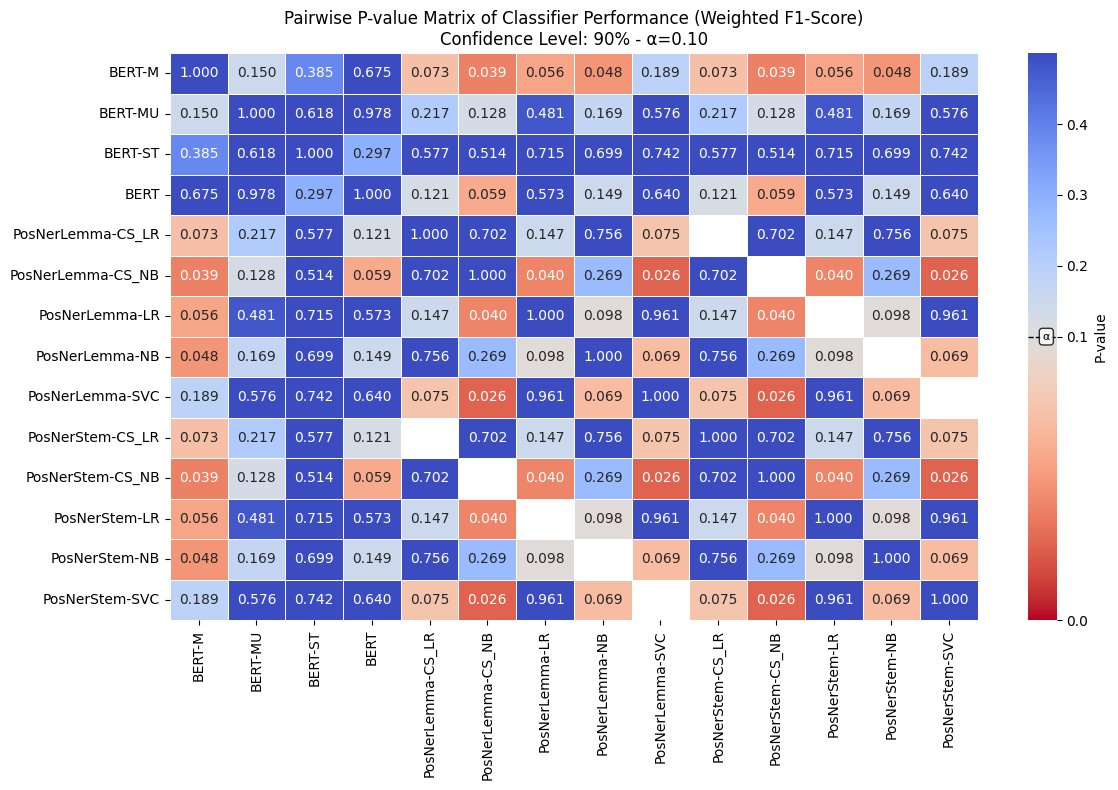

In [402]:
p_matrix_90 = plot_pvalue_matrix(all_scores, confidence_level=0.90, title_suffix="α=0.10")

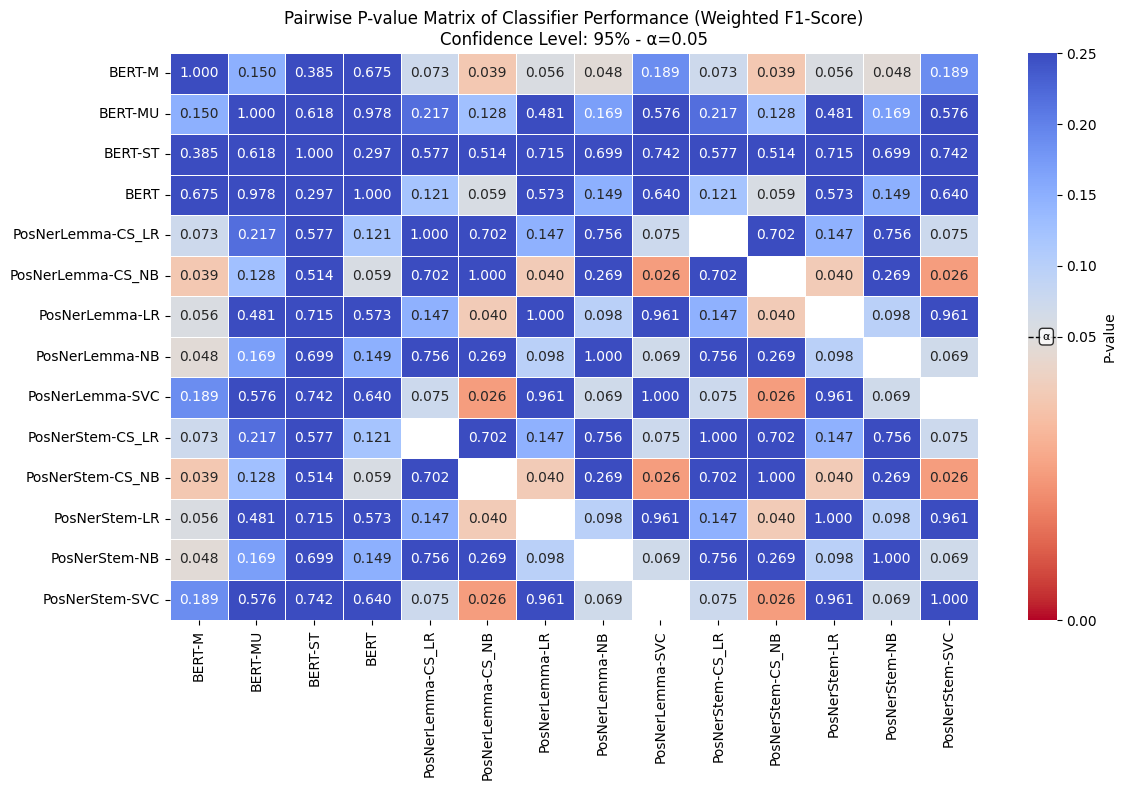

In [403]:
p_matrix_95 = plot_pvalue_matrix(all_scores, confidence_level=0.95, title_suffix="α=0.05")

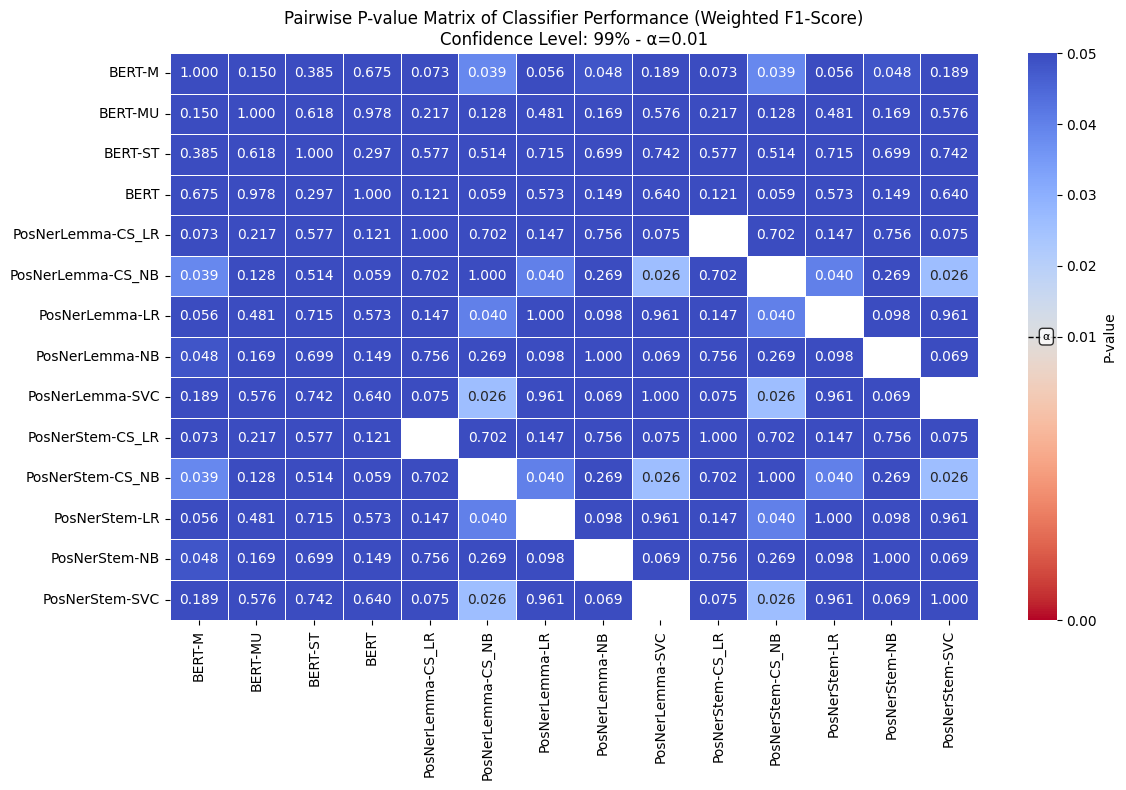

In [404]:
# Plot with 99% confidence (α = 0.01)
p_matrix_99 = plot_pvalue_matrix(all_scores, confidence_level=0.99, title_suffix="α=0.01")